In [112]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import Linear, MSELoss, Sequential, Sigmoid, Softmax, ReLU, LeakyReLU, Module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from scipy.interpolate import make_interp_spline, BSpline

In [113]:
df = pd.read_csv('elapsed-time-control-group.csv')
df

,vms,elapsed
0,10,19.6
1,10,22.3
2,20,40.1
3,20,40.9
4,30,63.1
5,30,60.3
6,40,100.0
7,40,104.8
8,50,132.0
9,50,142.3


In [114]:
df.corr()

,vms,elapsed
vms,1.000000,0.986059
elapsed,0.986059,1.000000


In [115]:
df = df.dropna() # drop all rows that have NAN/none

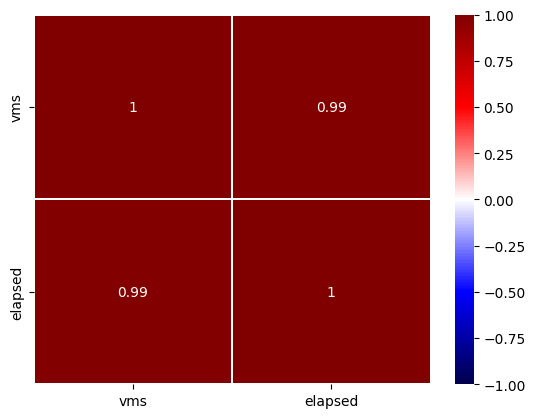

In [116]:
# plt.figure(figsize=(10,10))
sb.heatmap( df.corr(), vmin=-1, vmax=1, annot=True, linewidths=0.2, cmap='seismic' )
plt.show()

In [117]:
df = df.dropna() # drop all rows that have NAN/none
df.insert(0, "squared_vms", df['vms']**2, True)
df

,squared_vms,vms,elapsed
0,100,10,19.6
1,100,10,22.3
2,400,20,40.1
3,400,20,40.9
4,900,30,63.1
5,900,30,60.3
6,1600,40,100.0
7,1600,40,104.8
8,2500,50,132.0
9,2500,50,142.3


In [118]:
x_data = df.iloc[:,:2].values # 0, 1 열 (x^2 + x)
y_data = df.iloc[:,[-1]].values  # 마지막 열만
print(x_data.shape)

(10, 2)


In [119]:
scaleF = MinMaxScaler()
x_dataN = scaleF.fit_transform( x_data )

scaleL = MinMaxScaler()
y_dataN = scaleL.fit_transform( y_data )
y_dataN.shape

x_dataN

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.125     , 0.25      ],
       [0.125     , 0.25      ],
       [0.33333333, 0.5       ],
       [0.33333333, 0.5       ],
       [0.625     , 0.75      ],
       [0.625     , 0.75      ],
       [1.        , 1.        ],
       [1.        , 1.        ]])

In [120]:
x = torch.FloatTensor(x_dataN) # 특성 데이터
y = torch.FloatTensor(y_dataN) # 라벨

In [121]:
class ExpModel(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2,1)
    
    def forward(self, x):        
        x = self.fc1(x)
        
        return x   

In [122]:
# model = Sequential()
# model.add_module('nn1', Linear(1,1))
model = ExpModel()
list(model.parameters())

[Parameter containing:
 tensor([[0.1648, 0.2244]], requires_grad=True),
 Parameter containing:
 tensor([-0.0949], requires_grad=True)]

In [123]:
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=0.1)

In [124]:
hist = []
for step in range(2000):
    optimizer.zero_grad()
    hx = model.forward(x) # w*x+b # hx = model(x)
    cost = loss_fn(hx, y)
    cost.backward()
    optimizer.step()
    if step % 100 == 0:
        print(step, cost.item())
    hist.append(cost.item())

0 0.1622408926486969
100 0.0010267386678606272
200 0.0009357765084132552
300 0.0009161757188849151
400 0.0009139183675870299
500 0.0009137728484347463
600 0.0009137668530456722
700 0.000913766969460994
800 0.0009137671440839767
900 0.0009137666784226894
1000 0.000913766969460994
1100 0.0009137666784226894
1200 0.0009137672604992986
1300 0.0009137672604992986
1400 0.0009137672604992986
1500 0.0009137665037997067
1600 0.0009137670276686549
1700 0.0009137667948380113
1800 0.0009137671440839767
1900 0.0009137673187069595


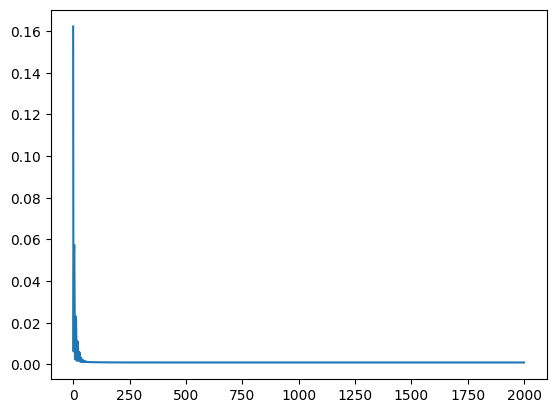

In [125]:
plt.plot(hist)
plt.show()

## w,b검정지표: 결정계수(선형회귀)
- 0 <= 결정계수 <= 1 (0.5 이상이면 예측으로 활용가능하다.)
- 1 - (오차의 제곱합)/(편차의 제곱합)
- 오차: 실제 값과 예측 값의 차이
- 편차: 실제 값과 평균 값의 차이

In [126]:
list(model.parameters())

[Parameter containing:
 tensor([[0.6972, 0.2622]], requires_grad=True),
 Parameter containing:
 tensor([0.0098], requires_grad=True)]

In [127]:
pred = model(x).detach().numpy()
pred

array([[0.00984981],
       [0.00984981],
       [0.16255675],
       [0.16255675],
       [0.3733613 ],
       [0.3733613 ],
       [0.64226335],
       [0.64226335],
       [0.96926296],
       [0.96926296]], dtype=float32)

In [128]:
r2_score(y_dataN, pred)

0.9922781792287055

In [129]:
# Dummy data to draw smooth graph
x_axis = np.linspace(1,50,50) # [ 1 , 2, 3, 4, ...., 50]
x_dummy = [[xval**2, xval] for xval in x_axis]
scaleF = MinMaxScaler()
x_dummyN = scaleF.fit_transform( x_dummy )

y_dummyN = model(torch.FloatTensor(x_dummyN)).detach().numpy()
y_dummy = scaleL.inverse_transform(y_dummyN)

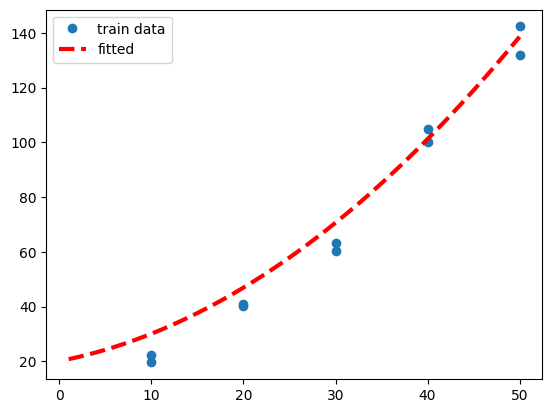

In [130]:
# plt.ylim([0, 25000])
plt.plot(x_data[:,[1]], y_data, 'o', label='train data')
# plt.scatter(x_data, y_data)
# plt.plot(x_data[:,1], np.exp(model(x).data.numpy()), '-r', linewidth=3, label='fitted') # r-- : Red, dashed line

plt.plot(x_axis, y_dummy, 'r--', linewidth=3, label='fitted') # r-- : Red, dashed line
# plt.grid()
plt.legend()
plt.show()